In [9]:
import pandas as pd
from kan.custom_processing import (plot_data_per_interval,
                                   plot_activation_and_spline_coefficients, get_masks)
import matplotlib.pyplot as plt
import os
import datetime
import json
import numpy as np
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 75
plt.rcParams['savefig.dpi'] = 75*10

root_dir = os.path.join(os.getcwd())
save_dir = os.path.join(root_dir, "custom_figures")
time_stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M')

fn = "CO2RR_MSP_20251107_1856"
save_tag = fn + "_analysis"
save_heading = os.path.join(save_dir, save_tag)

df = pd.read_excel(os.path.join(root_dir, 'multkan_sweep_autosave', fn + ".xlsx"), sheet_name='best_avg_by_params')
d_opt = df

d_opt_flat = d_opt.iloc[0]
d_opt_flat = d_opt_flat.to_dict()
params = {k: v for k, v in d_opt_flat.items() if "param_" in k}
params = {key.replace('param_', ''): value for key, value in params.items()}

In [10]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"This script is running on {device}.")

filepath = os.path.join("..\TaeWoong", "25.01.14_CO2RR_GSA.xlsx")

xls = pd.ExcelFile(filepath)
df_in = pd.read_excel(xls, sheet_name='Input')
df_out = pd.read_excel(xls, sheet_name='Output')

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out)

removed_count = len(df_in) - len(df_in_final)  # 몇 개 지웠는지 세기
print(f"이상치 제거 후 데이터 수: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")
print("--- 이상치 제거 완료 ---\n")

name_X = [
    "Current density (mA/cm2)",
    "Faradaic efficiency (%)",
    "CO coversion",
    "Voltage (V)",
    "Electricity cost ($/kWh)",
    "Membrain cost ($/m2)",
    "Catpure energy (GJ/ton)",
    "Crossover rate"
]
name_y = "MSP ($/kgCO)"  # Required energy_total (MJ/kgCO) # MSP ($/kgCO)
X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)  # 0.2 × 0.8 = 0.16 (전체의 16%)

print(f"전체 데이터셋 크기: {len(X)}")
print(f"훈련셋 크기: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"검증셋 크기: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"테스트셋 크기: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

# 1. MinMaxScaler 객체 생성 --- 범위를 0.1~0.9로 재설정
scaler_X = MinMaxScaler(feature_range=(0.1, 0.9))
scaler_y = MinMaxScaler(feature_range=(0.1, 0.9))

X_train_norm = scaler_X.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 및 변환 (fit_transform)
y_train_norm = scaler_y.fit_transform(y_train)  # X_train의 각 변수(컬럼)별로 최소값은 0, 최대값은 1이 되도록 변환됩니다.

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

This script is running on cpu.
이상치 제거 후 데이터 수: 2378 개 (123 개 제거됨)
--- 이상치 제거 완료 ---

전체 데이터셋 크기: 2378
훈련셋 크기: 1521 (64.0%)
검증셋 크기: 381 (16.0%)
테스트셋 크기: 476 (20.0%)


| train_loss: 1.31e-02 | test_loss: 1.14e-02 | reg: 2.12e+00 | : 100%|█| 50/50 [00:25<00:00,  1.93it
| train_loss: 1.37e-02 | test_loss: 1.22e-02 | reg: 1.96e+00 | : 100%|█| 50/50 [00:30<00:00,  1.66it
| train_loss: 1.65e-02 | test_loss: 1.53e-02 | reg: 1.91e+00 | : 100%|█| 50/50 [00:19<00:00,  2.59it
| train_loss: 1.61e-02 | test_loss: 1.61e-02 | reg: 1.95e+00 | : 100%|█| 50/50 [00:26<00:00,  1.90it
| train_loss: 1.63e-02 | test_loss: 1.61e-02 | reg: 2.17e+00 | : 100%|█| 50/50 [00:27<00:00,  1.81it
| train_loss: 1.58e-02 | test_loss: 1.67e-02 | reg: 2.37e+00 | : 100%|█| 50/50 [00:23<00:00,  2.17it


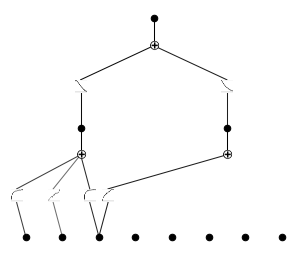

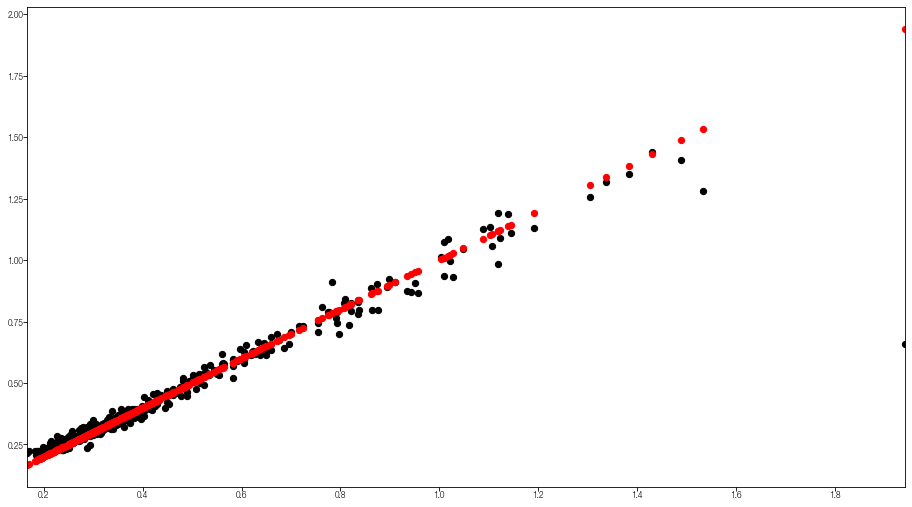

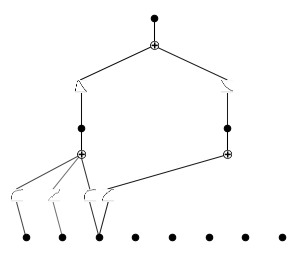

In [11]:
from kan.experiments.multkan_hparam_sweep import evaluate_params

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
print(res)
model.plot()
plt.show()

In [12]:
torch.save(model.state_dict(), f"{save_heading}_model.pt")

Text(0, 0.5, 'Attribution score')

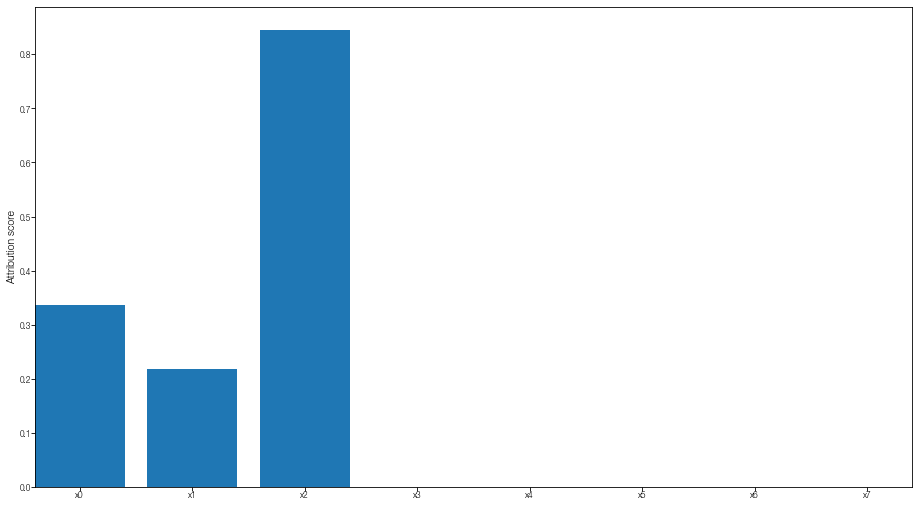

In [13]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

fig, ax = plt.subplots()
model.forward(torch.tensor(X_norm, dtype=torch.float32, device=device))
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

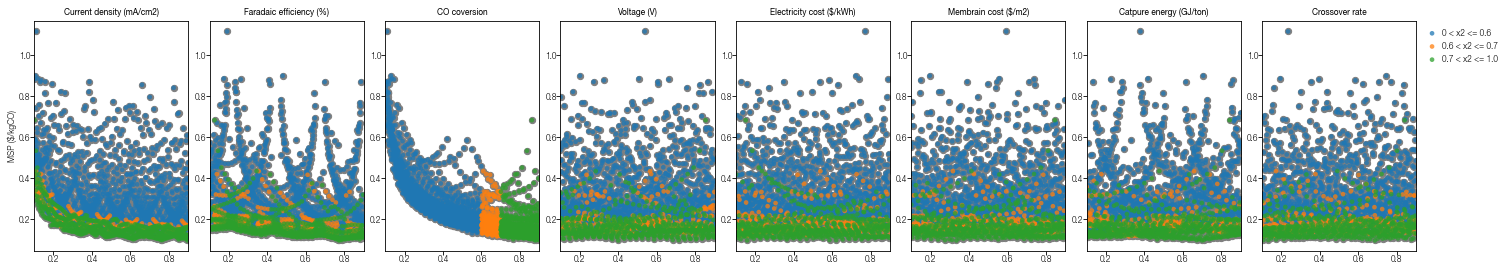

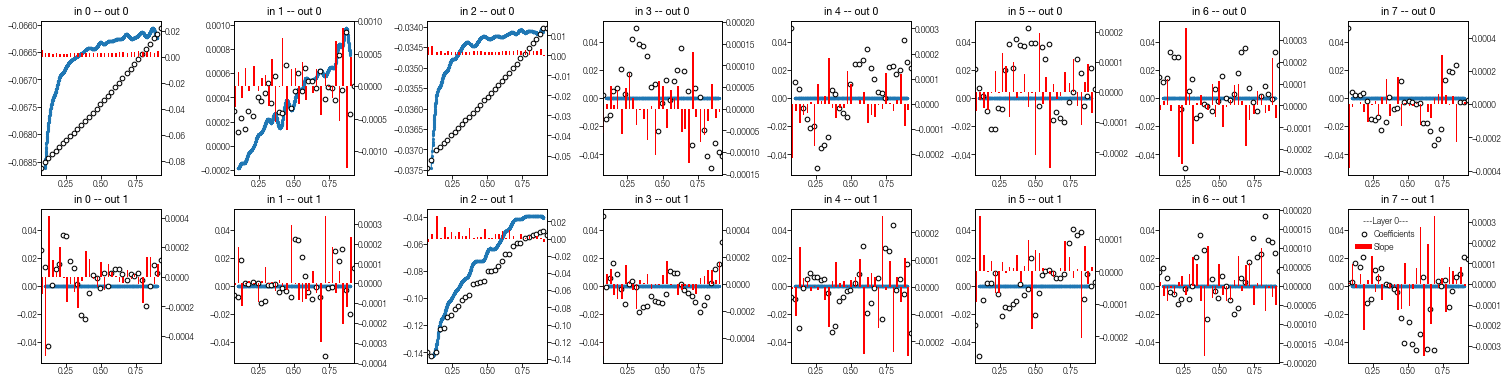

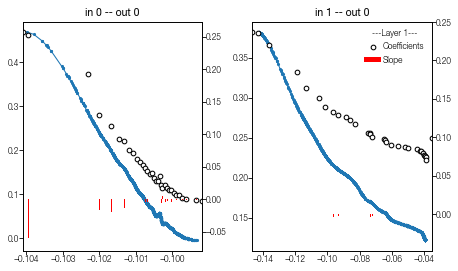

[<Figure size 1500x375 with 32 Axes>, <Figure size 450x262.5 with 4 Axes>]

In [14]:
from kan.custom_processing import plot_data_per_interval
from kan.experiments.multkan_hparam_sweep import _build_dataset
mask_idx = 2
mask_interval = [0, 0.6, 0.7]

# fig_x2, axs_x2 = plot_data_per_interval(X_norm, y_norm, name_X, name_y, 2, [0, 0.3, 0.6])
fig_x2, axs_x2 = plot_data_per_interval(X_norm, y_norm, name_X, name_y, mask_idx, mask_interval)

dataset = _build_dataset(X_train_norm, y_train_norm, X_val_norm, y_val_norm, X_test_norm, y_test_norm, device)
plot_activation_and_spline_coefficients(model, save_heading=save_heading, x=dataset, layers=None)

[1477, 1778, 901]


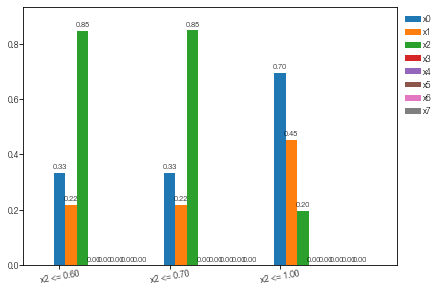

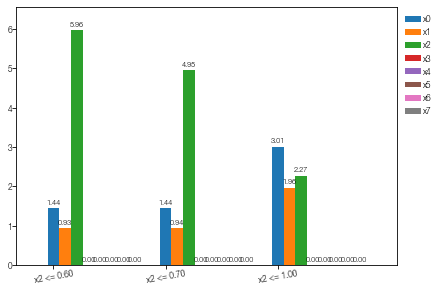

In [15]:
x_mask = X_norm[:, mask_idx]
y_vals = y_norm.ravel()  # y가 (N,1)이어도 (N,)으로 평탄화

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip([0.] + mask_interval[:-1], mask_interval[1:] + [1.])]
labels = [f'x{mask_idx} <= {ub:.2f}' for lb, ub in zip([0.] + mask_interval[:-1], mask_interval[1:] + [1.])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_normalized = []
for mask in masks:
    if np.any(mask):
        x_masked = X_norm[mask, :]
        x_tensor_masked = torch.tensor(x_masked, dtype=torch.float32, device=device)
        model.forward(x_tensor_masked)

        std = x_tensor_masked.std(dim=0)
        score = model.feature_score.detach().cpu().numpy()
        score_norm = score / std
        scores_interval.append(score)
        scores_interval_normalized.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_normalized.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

fig_norm, ax_norm = plt.subplots(figsize=(6,4))
max_score = max([max(s) for s in scores_interval_normalized])
for idx in range(scores_tot.shape[0]):
    bars = ax_norm.bar(xticks + idx * width, [s[idx] for s in scores_interval_normalized], width, label=f"x{idx}")
    ax_norm.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax_norm.margins(x=0.1)
ax_norm.set_ylim(0, max_score * 1.1)

ax_norm.set_xticks(xticks)
ax_norm.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax_norm.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

| train_loss: 1.37e-02 | test_loss: 1.20e-02 | reg: 2.08e+00 | : 100%|█| 50/50 [00:23<00:00,  2.09it
| train_loss: 1.31e-02 | test_loss: 1.13e-02 | reg: 2.04e+00 | : 100%|█| 50/50 [00:25<00:00,  1.94it
| train_loss: 1.60e-02 | test_loss: 1.49e-02 | reg: 1.92e+00 | : 100%|█| 50/50 [00:16<00:00,  3.03it
| train_loss: 1.61e-02 | test_loss: 1.56e-02 | reg: 2.01e+00 | : 100%|█| 50/50 [00:19<00:00,  2.54it
| train_loss: 1.57e-02 | test_loss: 1.57e-02 | reg: 2.22e+00 | : 100%|█| 50/50 [00:20<00:00,  2.49it
| train_loss: 1.58e-02 | test_loss: 1.70e-02 | reg: 2.42e+00 | : 100%|█| 50/50 [00:19<00:00,  2.56it


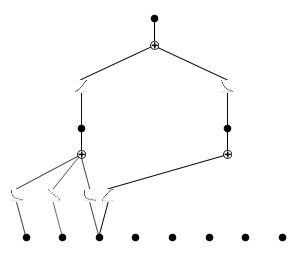

r2 is 0.9958155155181885
fixing (0,0,0) with 1/x, r2=1.0, c=2
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,1) with 0
Best value at boundary.
r2 is 0.9632898569107056
fixing (0,1,0) with x, r2=0.96, c=1
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,1,1) with 0
Best value at boundary.
r2 is 0.6224470138549805
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,2,0) with x, r2=0.62, c=1
r2 is 0.9640435576438904
fixing (0,2,1) with x, r2=0.96, c=1
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,0) with 0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,3,1) with 0
Best value at boundary.

| train_loss: 2.60e-02 | test_loss: 7.76e-02 | reg: 6.77e-01 | : 100%|█| 50/50 [00:05<00:00,  9.33it


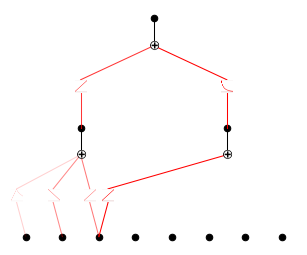

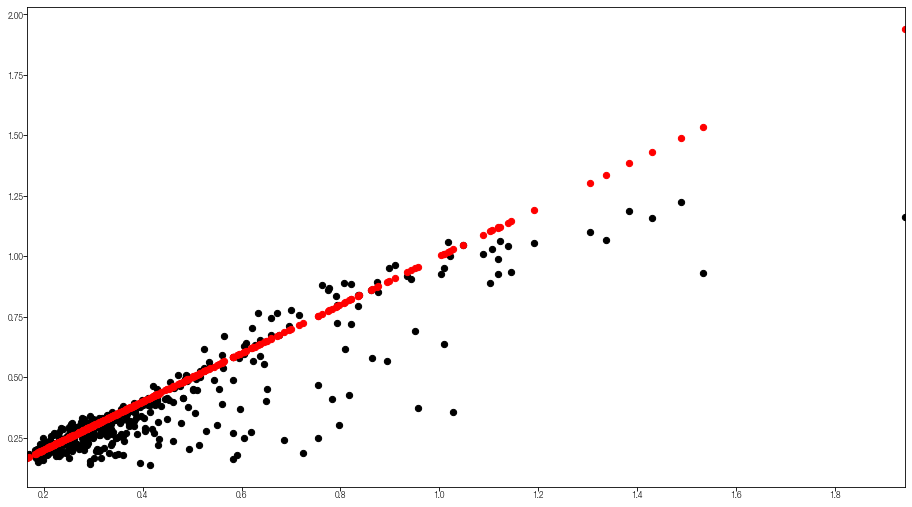

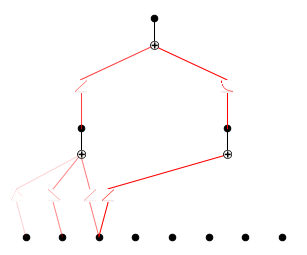

In [19]:
import copy

params_sym = copy.deepcopy(params)
params_sym['symbolic'] = True
# params_sym['sym_weight_simple'] = 0.

res, model, fit_kwargs, dataset = evaluate_params(
    X_train_norm, y_train_norm, X_val_norm, y_val_norm, params_sym, X_test_norm, y_test_norm, 0, scaler_y, device.type,
    save_heading=save_heading
)
model.plot()
plt.show()

In [18]:
print(res)

TrialResult(params={'lamb': 0.001, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.1, 'lamb_entropy': 0.1, 'lr': 0.1, 'max_grid': 30, 'prune': True, 'pruning_th': 0.05, 'update_grid': True, 'width': [[8, 0], [8, 0], [1, 0]], 'symbolic': True, 'sym_weight_simple': 0.0}, val_loss=0.07794180512428284, train_loss=0.07907494902610779, test_loss=0.08404868096113205, r2_train=0.7764799867484318, r2_val=0.8130576354838606, r2_test=0.7794240217962446, seed=0, device='cpu', spline_train_loss=0.19359071552753448, spline_test_loss=0.20265769958496094)
